# Analysis of Access to Health Care using openrouteservice - Kano
> Note: All notebooks need the [environment dependencies](https://github.com/GIScience/openrouteservice-examples#local-installation)
> as well as an [openrouteservice API key](https://openrouteservice.org/dev/#/signup) to run

prepare environment dependencies document

## Abstract
The rapid growth of urban areas has put substantial pressure on local services and infrastructure, particularly in African cities. With migrants moving into cities and transient households moving within cities, traditional means of collecting data (e.g., censuses and household surveys) are inadequate and often overlook informal settlements and households. As a consequence, there is a chronic lack of basic data about deprived households and entire settlements. Given that urban poor residents rely predominantly on private and informal service providers for healthcare and other services, they are rarely captured in routine service data, including health information management systems. This is especially true for women and young people who often work in the informal sector. 

In this example we will focus on vulnerability in terms of access to healthcare of slum areas in Lagos (Nigeria) , Kano (Nigeria), and Nairobi (Kenya).Quantifying and visualizing such inequalities is the aim of this notebook.

The notebook gives an overview on health sites distribution in these three cities and the barriers with access to those by foot and by car. Open source data from OpenStreetMap and tools (such as the openrouteservice) were used to create accessibility 10-minute walking and driving isochrones for each healthcare facility. Spatial join analysis was employed to integrate 100x100m grid cells with the isochrone layers, categorizing the barriers to healthcare access into three levels: low, medium, and high.


### Workflow:
* **Preprocessing**: Get data for district boundaries, slum areas (100x100m grid cells) and health facilities.
* **Analysis**:
    * Compute accessibility to health care facilities using openrouteservice API
    * Spatial join 100x100m grid cells with isochrone layers.
* **Result**: Visualize results as maps.


### Datasets and Tools:
* [Shapefile of district boundaries][boundaries] - Admin Level 2 (data from Humanitarian Data Exchange, 25/11/2015)
* [Shapefile of health facilities][facilities] (data from GRID3, 12/04/2023)
* [openrouteservice][ors] - generate isochrones on the OpenStreetMap road network

[boundaries]: https://data.humdata.org/dataset/nigeria-admin-level-2
[facilities]: https://data.grid3.org/datasets/1b358b47e41244cbaaccb640d9a4bfc9_0/about
[ors]: https://openrouteservice.org/

# Python Workflow

This study integrates various Python geospatial analysis libraries and packages to support spatial data processing, visualization, and isochrone generation. The os module is used to interact with the operating system, managing file paths and reading environment variables such as API keys. folium library along with its MarkerCluster plugin, facilitates the creation of interactive maps for visualizing large-scale geospatial data. The openrouteservice.client serves as an interface to the OpenRouteService API, enabling the extraction of isochrones. pandas library for data analysis, provides functions for analyzing, cleaning, exploring, and manipulating data, while fiona supports reading and writing real-world data using multi-layered GIS formats, such as shapefiles. The shapely package is employed for the manipulation and analysis of planar geometric objects.

In [6]:
import os
from IPython.display import display

import folium
from folium.plugins import MarkerCluster
from openrouteservice import client

import time
import pandas as pd
import fiona as fn
from shapely.geometry import shape, mapping
from shapely.ops import cascaded_union

## Preprocessing
In this study, users first requested an API key from the [OpenRouteService](https://openrouteservice.org/) platform and subsequently interacted with the OpenRouteService API through the instantiation of the OpenRouteService client. This is the OpenRouteService [API documentation](https://openrouteservice.org/dev/#/api-docs/introduction) for ORS Core-Version 9.0.0. 

Generate a [API Key](https://openrouteservice.org/dev/#/home?tab=1) (Token) it is necessary to sign up at the OpenRouteService dashboard by using your E-mail address or sign up with your GitHub. After logging in, go to the Dashboard by clicking on your profile icon and navigate to the API Keys section. Click "Create API Key" to generate a free key and then choose a service plan (the free plan has limited requests per day). Copy the API Key and store it securely. 

OpenRouteService primarily uses API keys for authentication. However, if a token is required for certain endpoints, you can send a request with your API key in the Authorization header. This process facilitated various geospatial analysis functions, including isochrone generation.

In [4]:
# insert your ORS api key
api_key = 'your_api_key'
ors = client.Client(key=api_key)

For this study different kind of data were used. The dataset on healthcare facilities is sourced from the GRID3 Data Hub (2023), which provides detailed spatial information on the locations of healthcare facilities within the Kano study area. The Level 2 administrative boundary data for Kano are used to correlate the isochrones and healthcare facility distribution with specific administrative regions

* [Shapefile of district boundaries](https://data.humdata.org/dataset/nigeria-admin-level-2) - Admin Level 2 (data from Humanitarian Data Exchange, 25/11/2015)
* [Shapefile of health facilities](https://data.grid3.org/datasets/1b358b47e41244cbaaccb640d9a4bfc9_0/about) (data from GRID3, 12/04/2023)

Describe filter criteria

In [3]:
# Set paths to access data
data_inputs = '../data_inputs/'
data_temp = '../data_temp/'
data_outputs = '../data_outputs/'

In [4]:
# make sure to provide the right filenames
health_facilities_filename = data_inputs + 'healthcare_facilites.shp'
districts_filename = data_inputs + 'administrative_level2.shp'

### Create district dictionary and facilities dictionary
In conducting geospatial analysis, we created dictionaries containing district information and healthcare facility information to achieve efficient data management and subsequent analysis.

In [5]:
districts_dictionary = {}
with fn.open(districts_filename, 'r') as districts:
    for feature in districts:
        district_id = int(feature['id'])
        districts_dictionary[district_id] = {
            'District Code': feature['properties']['LGACode'],
            'District Name': feature['properties']['LGAName'],
            'Population Count': 0,
            'Car: Pop. with access': 0,
            'Car: Pop. with access [%]': 0.0,
            'Foot: Pop. with access': 0,
            'Foot: Pop. with access [%]': 0.0,
            'geometry': feature['geometry']
        }
print('created dictionary for %s districts' % len(districts_dictionary))

facilities_dictionary = {}
with fn.open(health_facilities_filename, 'r') as facilities:
    for feature in facilities:
        facility_id = int(feature['id'])
        facilities_dictionary[facility_id] = {
            'geometry': feature['geometry']
        }
print('created dictionary for %s facilities' % len(facilities_dictionary))

created dictionary for 44 districts
created dictionary for 581 facilities


### An overview and look at a map of the districts and health facilities
First a map were created with [Folium](https://python-visualization.github.io/folium/latest/) to visualize data manipulated in Python. The boundaries of the districts as well as the health sites were given as shapefiles, which were printed on the map. 

In [6]:
map_outline = folium.Map(tiles='Stamen Toner', location=([-18.812718, 46.713867]), zoom_start=5)

# Import health facilities
cluster = MarkerCluster().add_to(map_outline)  # To cluster hospitals

for facility_id in facilities_dictionary:
    folium.Marker(list(reversed(facilities_dictionary[facility_id]['geometry']['coordinates']))).add_to(cluster)

# Import district boundaries
district_simp = []
for district_id in districts_dictionary:
    geom = shape(districts_dictionary[district_id]['geometry'])
    # we simplify the geometry just for the purpose of visualisation
    # be aware that some browsers e.g. chrome might fail to render the entire map if there are to many coordinates
    simp_geom = geom.simplify(0.005, preserve_topology=False)
    simp_coord = mapping(simp_geom)
    folium.GeoJson(simp_coord).add_to(map_outline)
    district_simp.append(simp_coord)

#change to variable
map_outline.save(os.path.join(data_outputs + 'healthcare_facilities_overview.html'))
map_outline

## Analysis
We will follow these steps:
* Get Isochrones from openrouteservice
* Perform Spatial Join
* Save output as GeoPackage file and CSV file

### Get Isochrones from OpenRouteService
Due to the limited road networks in the slum areas of these three cities, the accessibility of hospitals within a 10-minute range is of significant concern. Therefore, isochrones with 10 minutes walk range and 10 minutes car drive range around each hospital were created with the open source tool [OpenRouteService](https://openrouteservice.org/). This might take several minutes depending on the number of health facilities (currently we can send 40 requests per minute).

In [5]:
# request isochrones from ORS api for car
request_counter = 0
iso_car = []
for facility_id in facilities_dictionary.keys():
    loc = facilities_dictionary[facility_id]
    try:
        iso_params = {'locations': [loc['geometry']['coordinates']],
            'profile': 'driving-car',
            'range_type': 'time',
            'range': [1800],  # 1800 seconds = 30mins
            'attributes': ['total_pop', 'area']}
        request = ors.isochrones(**iso_params)

        request_counter += 1
        print(request_counter)
        lon, lat = loc['geometry']['coordinates']
        iso_car.append(shape(request['features'][0]['geometry']))
        if len(iso_car) % 35 == 0: 
            time.sleep(60) # try 20 here
        if len(iso_car) > 1000: # try 50
            break
    except Exception as err:
        print("there was an error and being skiped: " + str(err))
        pass
print('requested %s isochrones for car from ORS API' % request_counter)

# generate cascaded union of all isochrones,new package is unary_union
from shapely.ops import unary_union
iso_union_car = unary_union(iso_car)
print('Computed unary union of all isochrones')

# save isochrones to shapefiles
schema = {'geometry': 'Polygon',
          'properties': {'id': 'int'}}
index = 0

output_path = os.path.join(data_temp, "iso_car_30mins.shp")

with fn.open(output_path, 'w', 'ESRI Shapefile', schema) as c:
    if iso_union_car.geom_type == 'Polygon':
        # If the result is a single Polygon
        c.write({
            'geometry': mapping(iso_union_car),
            'properties': {'id': 1}
        })
    elif iso_union_car.geom_type == 'MultiPolygon':
        # If the result is a MultiPolygon
        for poly in iso_union_car.geoms:
            index += 1
            c.write({
                'geometry': mapping(poly),
                'properties': {'id': index}
            })
print('saved isochrones as shapefiles for car.')

NameError: name 'facilities_dictionary' is not defined

In [6]:
# request isochrones from ORS api for pedestrian
request_counter = 0
iso_foot = []
for facility_id in facilities_dictionary.keys():
    loc = facilities_dictionary[facility_id]
    try:
        iso_params = {'locations': [loc['geometry']['coordinates']],
            'profile': 'foot-walking',
            'range_type': 'time',
            'range': [900],  # 900 seconds = 15 mins walk 
            'attributes': ['total_pop', 'area']}
        request = ors.isochrones(**iso_params)
        request_counter += 1

        lon, lat = loc['geometry']['coordinates']
        iso_foot.append(shape(request['features'][0]['geometry']))
        if len(iso_foot) % 35 == 0: 
            time.sleep(60) # try 20 here
        if len(iso_foot) > 1000: # try 50
            break
    except Exception as err:
        pass
print('requested %s isochrones for foot from ORS API' % request_counter)

# generate cascaded union of all isochrones
from shapely.ops import unary_union
iso_union_foot = unary_union(iso_foot)
print('Computed unary union of all isochrones')

# Save isochrones to shapefiles
schema = {'geometry': 'Polygon',
          'properties': {'id': 'int'}}
index = 0

output_path = os.path.join(data_temp, "iso_foot_15mins.shp")

with fn.open(output_path, 'w', 'ESRI Shapefile', schema) as c:
    if iso_union_foot.geom_type == 'Polygon':
        # If the result is a single Polygon
        c.write({
            'geometry': mapping(iso_union_foot),
            'properties': {'id': 1}
        })
    elif iso_union_foot.geom_type == 'MultiPolygon':
        # If the result is a MultiPolygon
        for poly in iso_union_foot.geoms:
            index += 1
            c.write({
                'geometry': mapping(poly),
                'properties': {'id': index}
            })

print('Saved isochrones as shapefiles for pedestrian.')

requested 628 isochrones for foot from ORS API
Computed unary union of all isochrones
Saved isochrones as shapefiles for pedestrian.


### Spatial joins for the grid and isochrone layers using geopandas
This study employed the GeoPandas library to perform a spatial join between isochrone data and 100✖️100 grid cells, which allowed for the analysis and evaluation of accessibility for each grid cell within the study area in these three cities, across different time intervals (specifically by walking or driving). Accessibility was classified as three levels: high, medium and low. The analysis results were exported in GeoPackage format to ensure both the persistent storage and reusability of the data. Additionally, all spatial datasets were maintained in the same coordinate reference system (EPSG:4326), which ensured consistency and accuracy in the spatial joins and subsequent analyses.

In [2]:
# Spatial join analysis in GeoPandas
import geopandas as gpd

In [4]:
import fiona

with fiona.Env():
    layers = fiona.listlayers(data_inputs + "100mGrid.gpkg")
    grid_layer_name = layers[0]

['ka_dep_bin']


In [4]:
# Read grid cells and isochrones from the GeoPackage file
grid_gdf = gpd.read_file(data_inputs + "100mGrid.gpkg", layer=grid_layer_name)
isochrones_foot_gdf = gpd.read_file(data_temp + 'iso_foot_15mins.shp')
isochrones_car_gdf = gpd.read_file(data_temp + 'iso_car_30mins.shp')

# Ensure both GeoDataFrames have the same CRS
if isochrones_foot_gdf.crs is None:
    # Assign CRS if missing (assuming it's in EPSG:4326 like grid_gdf)
    isochrones_foot_gdf = isochrones_foot_gdf.set_crs("EPSG:4326")
else:
    # Reproject isochrones_gdf to match grid_gdf's CRS
    isochrones_foot_gdf = isochrones_foot_gdf.to_crs(grid_gdf.crs)

# Ensure both GeoDataFrames have the same CRS
if isochrones_car_gdf.crs is None:
    # Assign CRS if missing (assuming it's in EPSG:4326 like grid_gdf)
    isochrones_car_gdf = isochrones_car_gdf.set_crs("EPSG:4326")
else:
    # Reproject isochrones_gdf to match grid_gdf's CRS
    isochrones_car_gdf = isochrones_car_gdf.to_crs(grid_gdf.crs)

In [5]:
# Perform spatial join based on intersection
# To estimate whether isochrones are completely contained within grid cells using the within predicate
grid_isocar_gdf = gpd.sjoin(grid_gdf, isochrones_car_gdf, how="left", predicate="within") 
grid_isocar_gdf.rename(columns={'index_right': 'index_car', 'id': 'id_car'}, inplace=True)
# Save the result to a new GeoPackage file
grid_isocar_gdf.to_file(data_temp + "grid_iso_car_output.gpkg", layer="joined_layer", driver="GPKG")
print('join grid and isochrones car done')

join grid and isochrones car done


In [6]:
grid_isocarfoot_gdf = gpd.sjoin(grid_isocar_gdf, isochrones_foot_gdf, how="left", predicate="within")
grid_isocarfoot_gdf.rename(columns={'index_right': 'index_foot', 'id': 'id_foot'}, inplace=True)
grid_isocarfoot_gdf.to_file(data_temp + "grid_iso_car_output.gpkg", layer="joined_layer", driver="GPKG")
print('join grid and isochrones car and isochrones foot done')

join grid and isochrones car and isochrones foot done


In [7]:
# add a new column to the GeoDataFrame and set it to 2
grid_isocarfoot_gdf = grid_isocarfoot_gdf.assign(result=2)
# for values in the 'joined' column that are coming from the isochones by car set them to 1
grid_isocarfoot_gdf.loc[grid_isocarfoot_gdf['index_car'].notnull(), 'result'] = 1
# for values in the 'joined' column that are coming from the isochones by foot set them to 0
grid_isocarfoot_gdf.loc[grid_isocarfoot_gdf['index_foot'].notnull(), 'result'] = 0
grid_isocarfoot_gdf.to_file(data_outputs + "grid_iso_car_foot_output.gpkg", layer="joined_layer", driver="GPKG")

### Save Output as CSV file

In [8]:
grid_isocarfoot_gdf.to_csv(data_outputs + 'barrier_level.csv', 
                           columns=['latitude', 'longitude', 'lat_min', 'lat_max', 'lon_min', 'lon_max', 'result'])

## Correlation Matrix

In [47]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
import fiona

with fiona.Env():
    layers = fiona.listlayers(data_outputs + "grid_iso_car_foot_output.gpkg")
    layer_name = layers[0]

['joined_layer']


In [64]:
import fiona

with fiona.Env():
    layers = fiona.listlayers(data_inputs + "test_Kano_v3.gpkg")
    layer_name = layers[0]

['test_Kano_v3']


In [65]:
gdf_healthcare = gpd.read_file(data_outputs + "grid_iso_car_foot_output_Selected.gpkg", layer="layer_name")
gdf_morphology = gpd.read_file(data_inputs + "test_Kano_v3.gpkg", layer="layer_name")

In [66]:
print("Columns in healhcare dataset:", gdf_healthcare.columns)
print("Columns in morphology dataset:", gdf_morphology.columns)

Columns in healhcare dataset: Index(['dep_bin', 'latitude', 'longitude', 'lon_min', 'lat_min', 'lon_max',
       'lat_max', 'index_car', 'id_car', 'index_foot', 'id_foot', 'result',
       'geometry'],
      dtype='object')
Columns in morphology dataset: Index(['result', 'latitude', 'longitude', 'lon_min', 'lat_min', 'lon_max',
       'lat_max', 'geometry'],
      dtype='object')


In [67]:
gdf_joined = gpd.sjoin(gdf_healthcare, gdf_morphology, how="inner", predicate="intersects")

In [85]:
gdf_joined.to_file(data_temp + "kano_joined_data.gpkg", layer="joined_layer", driver="GPKG")

In [68]:
print(gdf_joined.columns)

Index(['dep_bin', 'latitude_left', 'longitude_left', 'lon_min_left',
       'lat_min_left', 'lon_max_left', 'lat_max_left', 'index_car', 'id_car',
       'index_foot', 'id_foot', 'result_left', 'geometry', 'index_right',
       'result_right', 'latitude_right', 'longitude_right', 'lon_min_right',
       'lat_min_right', 'lon_max_right', 'lat_max_right'],
      dtype='object')


In [69]:
columns_for_correlation = ['result_left', 'result_right', 'index_right']
df_for_correlation = gdf_joined[columns_for_correlation]

In [70]:
df_for_correlation

,result_left,result_right,index_right
0,1,0,407
972,1,0,407
1061,1,0,407
1062,1,0,407
1153,1,0,407
...,...,...,...
167221,1,0,167259
167222,1,0,167259
167223,1,0,167259
167258,1,0,167259


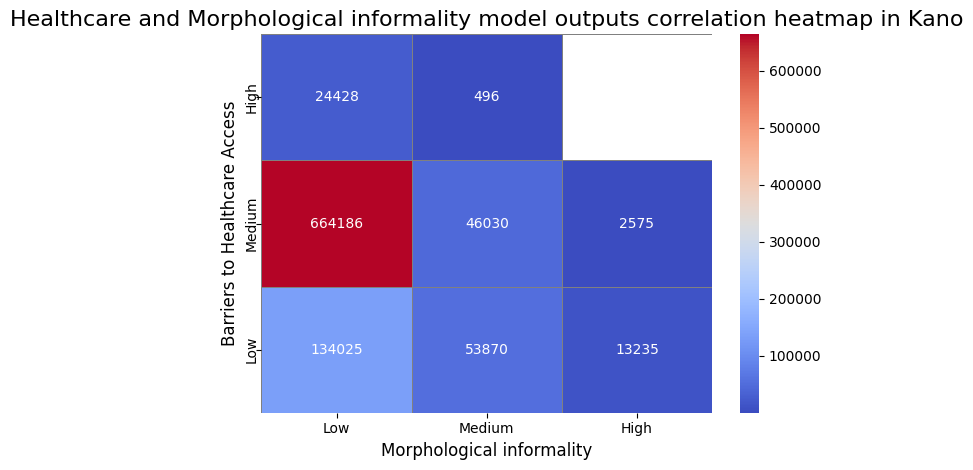

In [84]:
df_pivot = pd.pivot_table(df_for_correlation, values='index_right', index='result_left', columns='result_right',
                          aggfunc='count')

sns.heatmap( df_pivot, 
             annot=True,      
             cmap='coolwarm', 
             fmt='g',         
             linewidths=0.5,
             linecolor='gray')

df_pivot = df_pivot.fillna(0)

plt.gca().invert_yaxis()

plt.title("Healthcare and Morphological informality model outputs correlation heatmap in Kano", fontsize=16)
plt.xlabel("Morphological informality", fontsize=12)
plt.ylabel("Barriers to Healthcare Access", fontsize=12)

plt.xticks(ticks=[x + 0.5 for x in range(len(df_pivot.columns))], 
           labels=['Low', 'Medium', 'High'],
           ha='center', 
           fontsize=10)

plt.yticks(ticks=[x + 0.5 for x in range(len(df_pivot.index))],
           labels=['Low', 'Medium', 'High'],
           ha='center', 
           fontsize=10)

plt.tight_layout()
plt.show()

## Bivariate Choropleth Maps

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from matplotlib.colors import ListedColormap

In [3]:
import fiona

with fiona.Env():
    layers = fiona.listlayers(data_temp + "joined_data.gpkg")
    print(layers)

['joined_layer']


In [4]:
gdf = gpd.read_file(data_temp + "joined_data.gpkg", layer="joined_layer")

In [5]:
print(gdf.columns)

Index(['dep_bin', 'latitude_left', 'longitude_left', 'lon_min_left',
       'lat_min_left', 'lon_max_left', 'lat_max_left', 'index_car', 'id_car',
       'index_foot', 'id_foot', 'result_left', 'index_right', 'result_right',
       'latitude_right', 'longitude_right', 'lon_min_right', 'lat_min_right',
       'lon_max_right', 'lat_max_right', 'Bi_Class', 'geometry'],
      dtype='object')


In [6]:
healthcare_variable = 'result_left'  
morphological_variable = 'result_right'  

In [7]:
gdf['bivariate_class'] = gdf[healthcare_variable].astype(str) + "_" + gdf[morphological_variable].astype(str)

In [8]:
# Define the bivariate colors mapping
bivariate_colors = {
    '0_0': "#e8e8e8",  # HC: 0, MP: 0
    '0_1': "#e4d9ac",  # HC: 0, MP: 1
    '0_2': "#c8b35a",  # HC: 0, MP: 2
    '1_0': "#cbb8d7",  # HC: 1, MP: 0
    '1_1': "#c8ada0",  # HC: 1, MP: 1
    '1_2': "#af8e53",  # HC: 1, MP: 2
    '2_0': "#9972af",  # HC: 2, MP: 0
    '2_1': "#976b82",  # HC: 2, MP: 1
    '2_2': "#804d36"   # HC: 2, MP: 2 
}

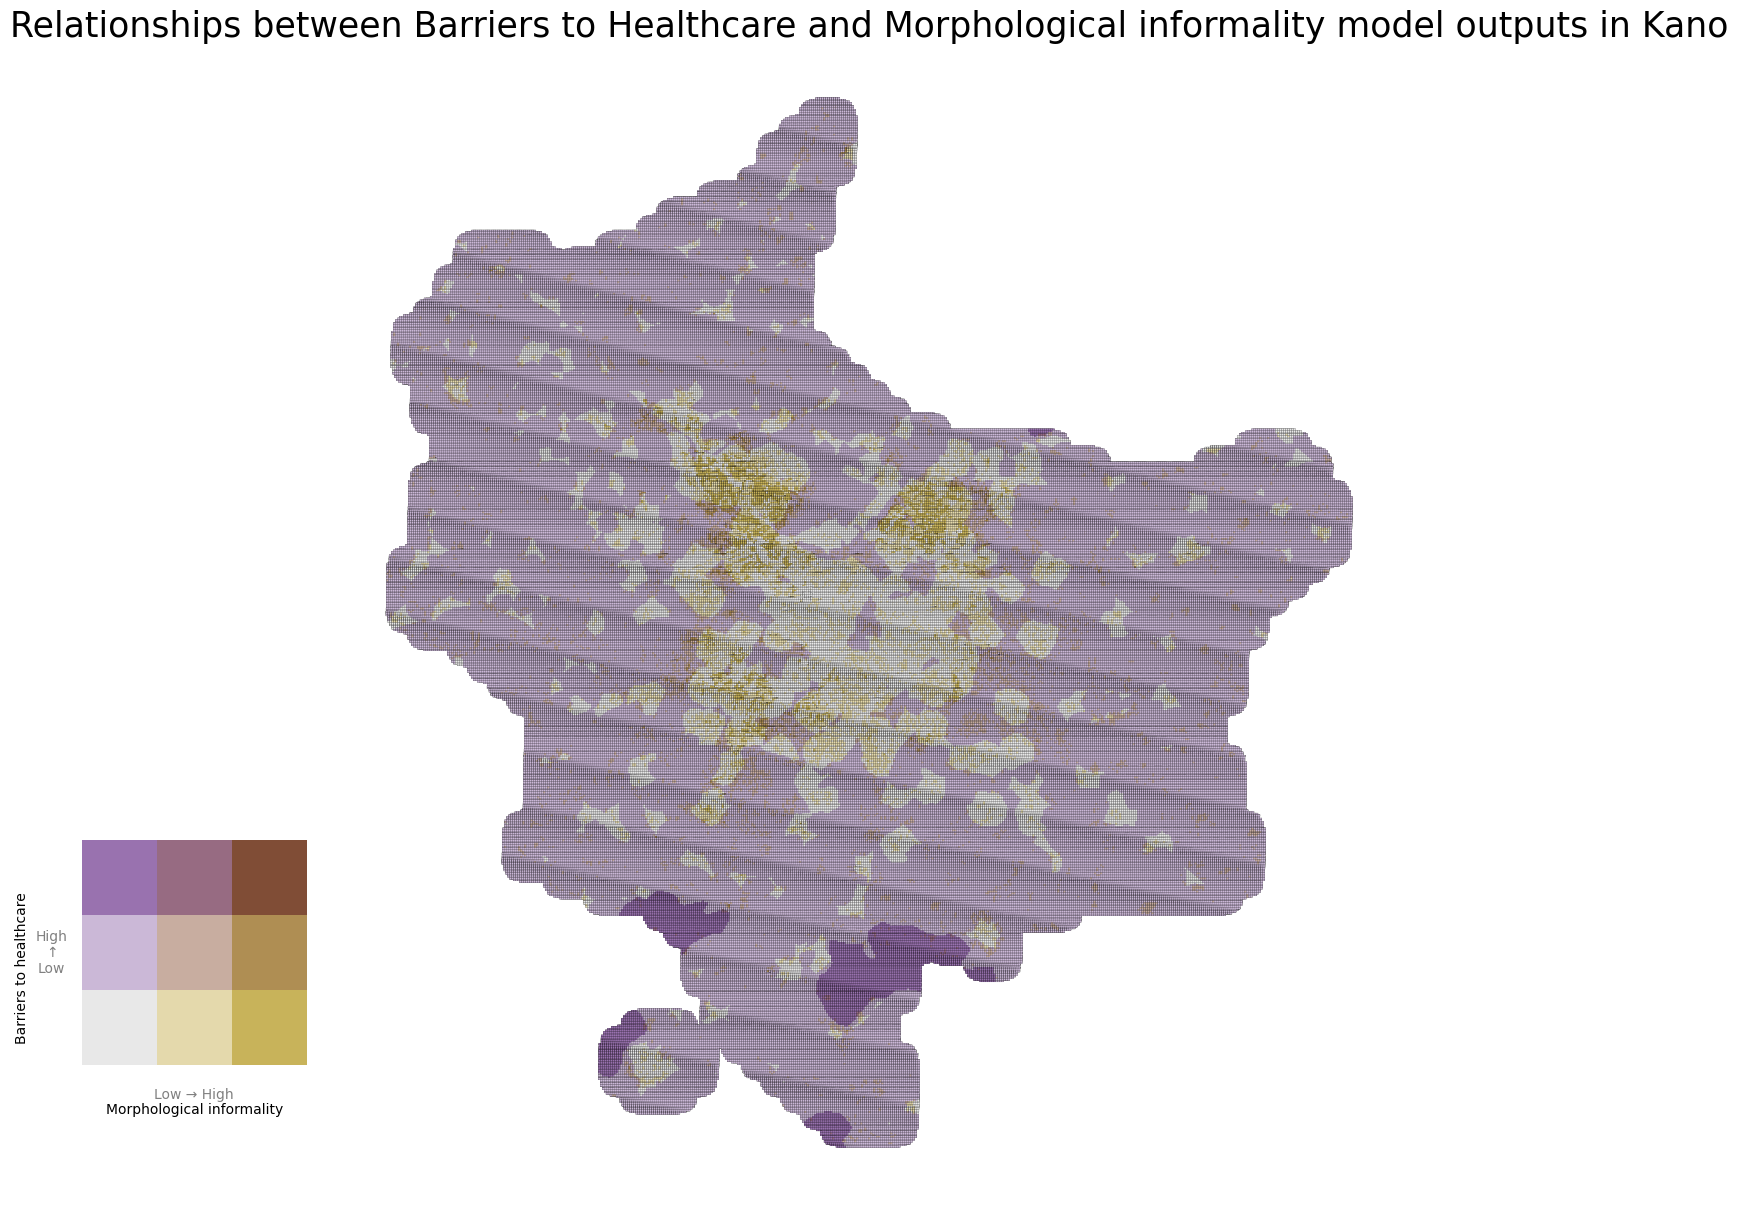

In [9]:
# Map colors to the bivariate_class
gdf['color'] = gdf['bivariate_class'].map(bivariate_colors)

# Create the main plot
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Plot the boundaries and the main data
gdf.boundary.plot(ax=ax, linewidth=0)
gdf.plot(ax=ax, color=gdf['color'], edgecolor='black', linewidth=0.1)

# Create a smaller axis for the legend, position it as a small square in the top-right corner
legend_ax = fig.add_axes([0.1, 0.2, 0.15, 0.15], aspect='equal') # Smaller and square-shaped
legend_ax.set_xticks([])
legend_ax.set_yticks([])

# Define the legend matrix colors in the correct order from left-bottom to right-top
legend_colors = [
    [bivariate_colors["2_0"], bivariate_colors["2_1"],bivariate_colors["2_2"]],
    [bivariate_colors["1_0"], bivariate_colors["1_1"], bivariate_colors["1_2"]],
    [bivariate_colors["0_0"], bivariate_colors["0_1"], bivariate_colors["0_2"]]
]

# Draw the legend matrix
for i in range(3):
    for j in range(3):
        rect = patches.Rectangle(
            (j, 2-i), 1, 1,  # Reverse the y-axis to position from bottom to top
            facecolor=legend_colors[i][j]
        )
        legend_ax.add_patch(rect)

# Set the limits of the legend axis
legend_ax.set_xlim(0, 3)
legend_ax.set_ylim(0, 3)

# Add axis labels for the legend

legend_ax.text(1.5, -0.4, 'Low → High', ha='center', va='center', fontsize=10, color='gray')
legend_ax.text(1.5, -0.6, 'Morphological informality', ha='center', va='center', fontsize=10, color='black')

# Vertical axis: Low ↑ High
legend_ax.text(-0.4, 1.5, 'High\n↑\nLow', ha='center', va='center', fontsize=10, color='gray', rotation=0)
legend_ax.text(-0.8, 1.3, 'Barriers to healthcare', ha='center', va='center', rotation=90, fontsize=10, color='black')

# Add long arrows for the legend
# Horizontal arrow (Low → High)
legend_ax.annotate('', xy=(1.5, -1.0), xytext=(1.5, -0.4),  # Long arrow end and start positions
            arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->', lw=1, mutation_scale=20))

# Vertical arrow (Low ↑ High)
legend_ax.annotate('', xy=(-1.0, 1.5), xytext=(-0.4, 1.5),  # Long arrow end and start positions
            arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->', lw=1, mutation_scale=20))

# Hide the legend axis frame
legend_ax.axis('off')

# Set the title for the main plot
ax.set_title('Relationships between Barriers to Healthcare and Morphological informality model outputs in Kano', fontsize=25)

# Hide the main plot's axis
ax.axis('off')

# Show the plot
plt.show()

## Results


## Conclusion
There is a small amount of hospitals in Madagascar, which are undistributed over the country.
Consequently, a high percentage of the population don't have fast access to health sites.
The findings show that the inhabitants of 69 of 119 districts don't have any access in a one-hour walking range,
and those of 43 of 119 districts in a one-hour car driving range.
The received maps (map_choropleth_foot and map_choropleth_car) show the population in percentage with access to
health facilities by foot and by car.

This study used open source data and tools. Therefore, results can be generated with a low amount money.
However, free data and tools can have limits for the analysis.
The data can show characteristics of incompleteness and inconsistency and the tools don't have for instance arranged
support for users.